In [41]:
import torch

from models import GNNModel

In [42]:
ckp_path = './experiments/2024-05-30 1732/0/checkpoints/epoch=191-step=1535999.ckpt'
checkpoint = torch.load(ckp_path, map_location=torch.device('cpu'))
hyper_parameters = checkpoint['hyper_parameters']

In [43]:
from models import NodeLevelGNN

state_dict = {}
for k, v in checkpoint['state_dict'].items():
    k = k.replace('.weight', '.lin.weight')
    if 'output_layers' in k:
        v = v.T
    if k == 'model.layers.0.lin.weight':
        v = v.T
    state_dict[k] = v
model = NodeLevelGNN(c_in=hyper_parameters['c_in'], c_hidden=30, c_out=hyper_parameters['c_out'], num_layers=20, m=8)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [44]:
from random import randint
from pyg import torch_geometric

p = .15

def get_lonely_vertex(g, n):
    degress = [0] * n
    for v in g[0]:
        degress[v] += 1

    try:
        return degress.index(0)
    except ValueError:
        return None


def create_graph(n):
    ei = torch_geometric.utils.erdos_renyi_graph(n, p)

    while True:
        v = get_lonely_vertex(ei, n)
        if not v:
            break

        u = randint(0, n-1)
        if u == v:
            continue
        new_edge = torch.tensor([[v, u], [u, v]])
        ei = torch.cat((ei, new_edge), 1)

    return ei

In [80]:
g = create_graph(10)
edge_list = [(int(a), int(b)) for a, b in g.T]

In [81]:
import networkx as nx

g_n = nx.from_edgelist(edge_list)
g_n

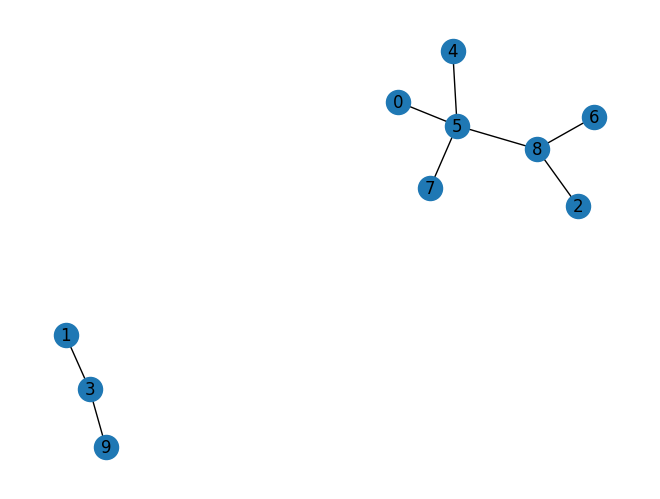

In [82]:
nx.draw(g_n, with_labels=True)

In [83]:
from pyg import geom_data
x = torch.Tensor([[1.]] * 10)
tg = geom_data.Data(x=x, edge_index=g)

model.model.eval()
results = model.model.forward(x, g)
results

tensor([[[-2.9447e+01],
         [-2.8086e+01],
         [-2.8048e+01],
         [-2.5723e+01],
         [-2.9447e+01],
         [-2.4552e+01],
         [-2.8048e+01],
         [-2.9447e+01],
         [-2.7110e+01],
         [-2.8086e+01]],

        [[-1.3269e+01],
         [-1.0356e+01],
         [-9.1426e+00],
         [-5.9141e+00],
         [-1.3269e+01],
         [-4.8373e+00],
         [-9.1426e+00],
         [-1.3269e+01],
         [-1.0968e+01],
         [-1.0356e+01]],

        [[ 1.9986e+00],
         [ 7.5593e-03],
         [-8.2232e-01],
         [-2.6690e+00],
         [ 1.9986e+00],
         [-2.8684e+00],
         [-8.2232e-01],
         [ 1.9986e+00],
         [ 9.3752e-01],
         [ 7.5593e-03]],

        [[-9.0090e-01],
         [-9.6189e-01],
         [-8.4002e-01],
         [-1.0994e+00],
         [-9.0090e-01],
         [-1.2203e+00],
         [-8.4002e-01],
         [-9.0090e-01],
         [-1.2751e+00],
         [-9.6189e-01]],

        [[-5.5212e+00],
        

In [84]:
maps = (torch.sigmoid(results) > .5).float()
maps

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]

In [88]:
y = torch.Tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0])
acc = (maps == y).sum(dim=1).float() / y.size(dim=0)
acc = acc.max()
acc

tensor(1.)

In [101]:
for i in range(8):
    print(maps[i][0] == y)

tensor([ True,  True,  True, False,  True, False,  True,  True, False,  True])
tensor([ True,  True,  True, False,  True, False,  True,  True, False,  True])
tensor([False, False, False,  True, False,  True, False, False,  True, False])
tensor([ True,  True,  True, False,  True, False,  True,  True, False,  True])
tensor([ True,  True,  True, False,  True, False,  True,  True, False,  True])
tensor([ True,  True,  True, False,  True, False,  True,  True, False,  True])
tensor([False, False, False,  True, False,  True, False, False,  True, False])
tensor([ True,  True,  True, False,  True, False,  True,  True, False,  True])
